# Multi Layer Perceptron

In [4]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook uses [%s]."%(device))

PyTorch version:[1.7.0+cu101].
This notebook uses [cuda:0].


### Set hyper-parameter

In [5]:
EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.001
print ("Done")

Done


### Prepare a dataset

In [7]:
# MNIST dataset
mnist_train = datasets.MNIST(
    root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(
    root='./data/', train=False, transform=transforms.ToTensor(), download=True)

train_iter = torch.utils.data.DataLoader(
    mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(
    mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print ("Done")

Done


### Define a Model

In [15]:
# our model
class Model(nn.Module):
    def __init__(self,input_features=784,hidden_size=256,output_fetures=10,
                 init_weight="he", init_bias="zero"):
        super(Model, self).__init__()
        self.init_weight = init_weight
        self.init_bias = init_bias
        self.linear1 = nn.Linear(input_features, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_fetures)
        self.init_params()

    def init_params(self):
        init_weight_method = {
            "he": nn.init.kaiming_normal_, 
            "xavier": nn.init.xavier_normal_
        }
        init_bias_method = {
            "zero": nn.init.zeros_, 
            "uniform": nn.init.uniform_
        }
        for param_name, param in self.named_parameters():
            if 'weight' in param_name:
                init_weight_method[self.init_weight](param)
            elif 'bias' in param_name:
                init_bias_method[self.init_bias](param)

    def forward(self, X):
        X = F.relu((self.linear1(X)))
        X = self.linear2(X)
        return X

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print ("Done")

Done


### Compute the number of parameters

In [16]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f"Number of Total Parameters: {total_params:,d}")

Number of Total Parameters: 203,530


### Define a helper function

In [25]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        test_loss = 0
        total = 0
        correct = 0
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 28*28).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
    return val_acc
print ("Done")

Done


### Train an MLP Model 

In [19]:
# Training Phase
print_every = 1
print("Start training !")
# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_iter:

        X = batch_img.view(-1, 28*28).to(device)
        Y = batch_lab.to(device)
        
        # Inference & Calculate loss
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_val_sum += loss
        
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        # accr_val = M.test(x_test, y_test, batch_size)
        loss_val_avg = loss_val_sum / len(train_iter)
        accr_val = test_eval(model, test_iter, BATCH_SIZE)
        print(f"epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]")
print("Training Done !")

Start training !
epoch:[1/10] cost:[0.023] test_accuracy:[97.920]
epoch:[2/10] cost:[0.020] test_accuracy:[97.810]
epoch:[3/10] cost:[0.017] test_accuracy:[97.920]
epoch:[4/10] cost:[0.013] test_accuracy:[97.910]
epoch:[5/10] cost:[0.012] test_accuracy:[97.860]
epoch:[6/10] cost:[0.010] test_accuracy:[97.780]
epoch:[7/10] cost:[0.008] test_accuracy:[97.960]
epoch:[8/10] cost:[0.007] test_accuracy:[98.050]
epoch:[9/10] cost:[0.006] test_accuracy:[97.950]
epoch:[10/10] cost:[0.005] test_accuracy:[97.910]
Training Done !


### Test an MLP Model

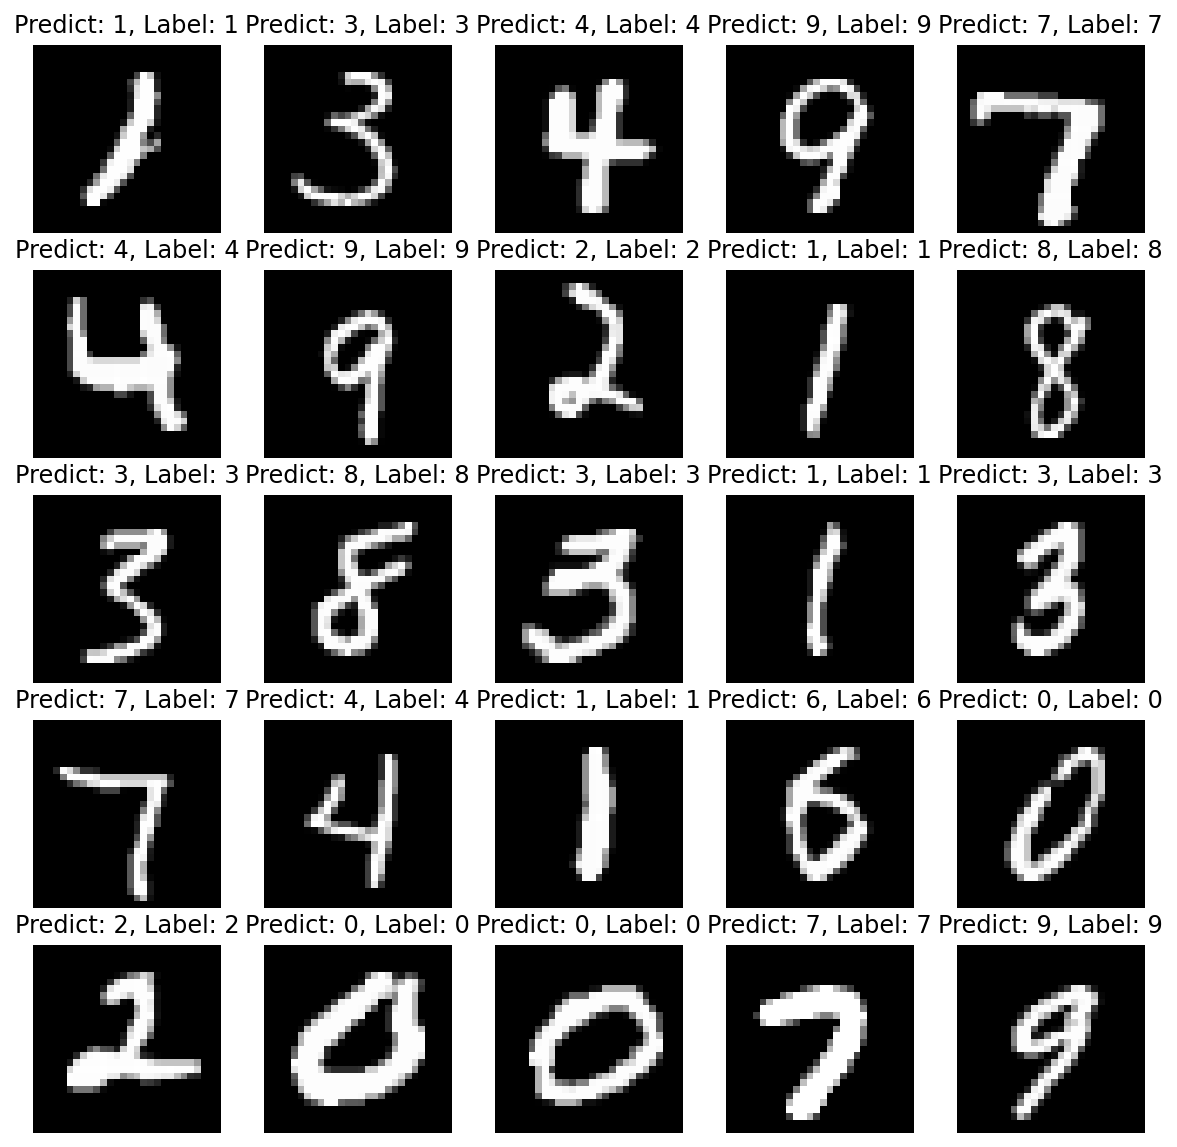

In [20]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    y_pred = model.forward(test_x.view(-1, 28*28).type(torch.float).to(device))

y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(10, 10))

for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"Predict: {y_pred[idx]}, Label: {test_y[idx]}")

plt.show()